# おまけ TensorflowでOCR(?) 評価


## やること

- tesseractの認識精度めっちゃ低かったので、自分で作ったほうが良いのではというナメた態度での試み
- 画像のテキストを１単語だけ抽出（雑ロジック）して、モデルに投げてみる
- 学習に利用したnotebookは「04_おまけ_TensorflowでOCR(?)_学習」で確認できる

## ハンズオン

### 必要なモジュールをimport

In [6]:
import utils  # 01_VisionAPIでOCR.ipynbで書いたコードを関数化したファイル
import json
from PIL import Image
import numpy as np
import cv2

In [676]:
def request_and_draw(np_img):
    _img = Image.fromarray(np_img)
    b64_encoded = utils.b64_encode(_img)
    res = utils.request_vision_api(bencoded_img=b64_encoded, api_key=api_key)
    content = json.loads(res.content)
    text_annotations = content['responses'][0]['textAnnotations']
    
    return text_annotations, utils.draw(_img, text_annotations)

### 今回利用する画像の読み込み

In [2]:
img = Image.open('../img/2.jpg')

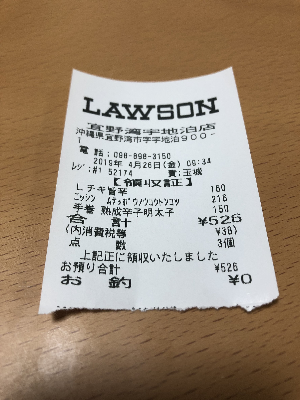

In [3]:
# 画像がでかいのでリサイズします
img.resize((300, 400))

In [7]:
np_img = np.array(img)

In [8]:
np_img.shape

(4032, 3024, 3)

In [10]:
gray_img = cv2.cvtColor(np_img, cv2.COLOR_RGB2GRAY)

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

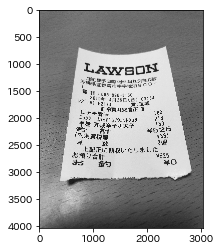

In [22]:
plt.imshow(gray_img, cmap='gray')
plt.show()

In [59]:
_, th_img = cv2.threshold(gray_img, 130, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# 膨張処理
kernel = np.ones([7, 7], np.uint8)
dilate = cv2.dilate(th_img, kernel, iterations=2)

# dilateした画像から元画像を引くと線画がうまく抽出できる
dilate_inv = dilate - th_img

# ↑で引いたら結果反転しているので255を引く
sub_img = 255 - dilate_inv

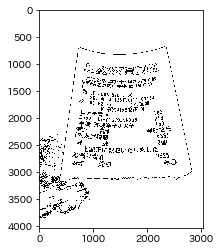

In [61]:
plt.imshow(sub_img, cmap='gray')
plt.show()

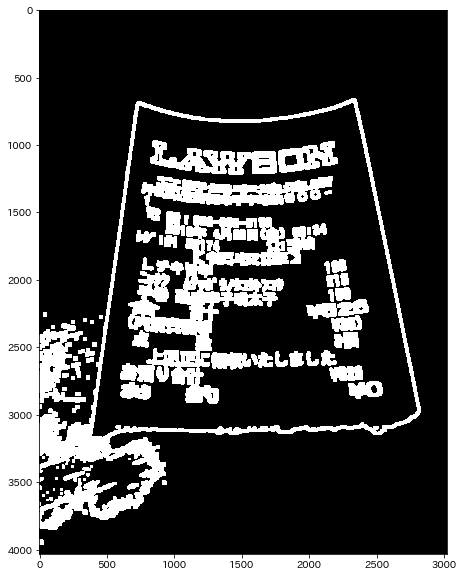

In [63]:
# 反転した画像をさらに膨張
kernel = np.ones([20, 20], np.uint8)
dilate2 = cv2.dilate(dilate_inv, kernel, iterations=1)
ga = cv2.GaussianBlur(dilate2, (11, 11), 0)
_, th = cv2.threshold(ga, 0, 200, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

_, ax = plt.subplots(figsize=(20, 10))
ax.imshow(th, cmap='gray')
plt.show()

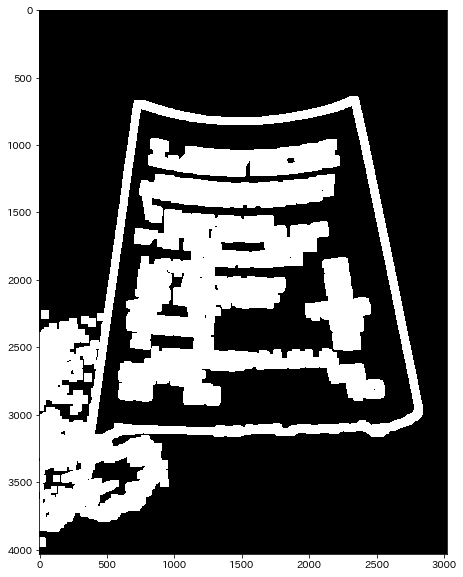

In [68]:
# 文字の箇所を極端に膨張させ
# 文字範囲を囲み処理で検出しやすいようにする
extreme_kernel = np.ones([30, 30])
th_dilate = cv2.dilate(th, extreme_kernel, iterations=1)

_, ax = plt.subplots(figsize=(20, 10))
ax.imshow(th_dilate, cmap='gray')
plt.show()

In [77]:
contours, _, = cv2.findContours(th_dilate.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

In [81]:
th = 10000
for idx, c in enumerate(contours):
    # サイズでフィルター
    size = cv2.contourArea(c)
    if size <= th:
        continue

    print(cv2.boundingRect(c))

(31, 3344, 296, 266)
(388, 3315, 404, 364)
(873, 1927, 235, 347)
(1968, 1833, 493, 694)
(1350, 1718, 326, 73)
(587, 1473, 1976, 1463)
(743, 1214, 1453, 365)
(809, 951, 1422, 285)
(412, 712, 2372, 2432)
(0, 640, 2845, 3231)


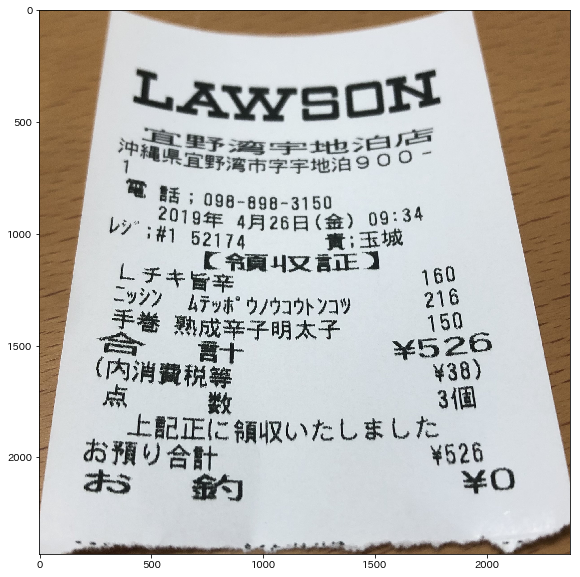

In [89]:
x, y, w, h = 412, 712, 2372, 2432

cut_img = np_img[y:y+h, x:x+w].copy()
_, ax = plt.subplots(figsize=(20, 10))
ax.imshow(cut_img, cmap='gray')
plt.show()

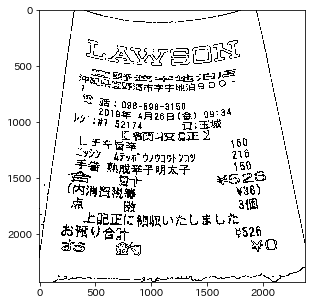

In [93]:
gray_img = cv2.cvtColor(cut_img, cv2.COLOR_RGB2GRAY)
_, th_img = cv2.threshold(gray_img, 130, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# 膨張処理
kernel = np.ones([7, 7], np.uint8)
dilate = cv2.dilate(th_img, kernel, iterations=2)

# dilateした画像から元画像を引くと線画がうまく抽出できる
dilate_inv = dilate - th_img

# ↑で引いたら結果反転しているので255を引く
sub_img = 255 - dilate_inv

_, ax = plt.subplots(figsize=(10, 5))
ax.imshow(sub_img, cmap='gray')
plt.show()

In [94]:
contours, _, = cv2.findContours(sub_img.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

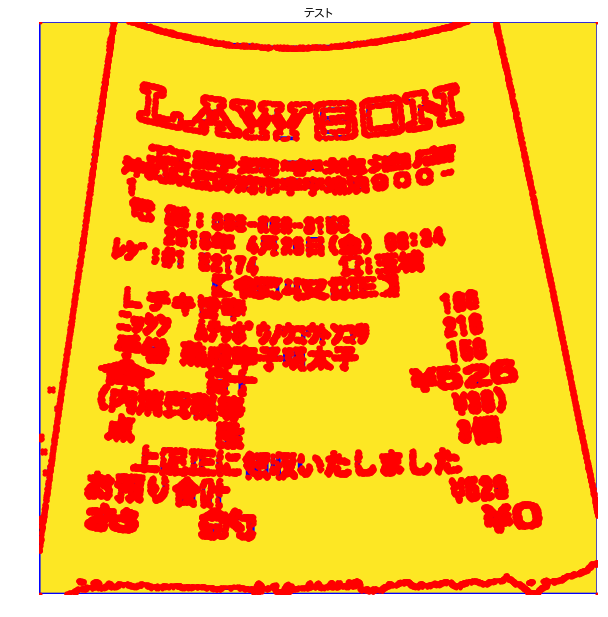

In [95]:
# 検出した矩形を描画
_, ax = plt.subplots(figsize=(10, 20))
ax.set_title('テスト')
draw_contours(ax, sub_img.copy(), contours)
plt.show()

In [171]:
# 小さい文字だけ取り出す
th_upper = 500
th_under = 300

th_upper_size = (700, 700)
th_under_size = (25, 25)

filtered_c = []
for idx, c in enumerate(contours):
    # サイズでフィルター
    size = cv2.contourArea(c)
    if th_under > size and size < th_upper:
        continue
    
    x, y, w, h = cv2.boundingRect(c)
    if th_under_size[0] > w or w > th_upper_size[0]:
        continue

    if th_under_size[1] > h or h > th_upper_size[1]:
        continue

    print(x, y, w, h)
    filtered_c.append(c)

742 2137 28 37
708 2137 26 43
814 2124 49 38
353 2113 49 45
874 2109 30 81
691 2081 168 105
680 2071 232 129
356 2071 54 36
1899 2063 95 94
223 2060 89 91
2038 2057 66 79
1885 2053 118 112
198 2051 212 115
2015 2044 112 106
584 1997 75 59
1765 1975 27 35
698 1956 29 90
688 1948 48 113
732 1946 68 117
340 1947 34 35
1746 1943 54 96
571 1939 109 58
1812 1937 52 95
465 1937 34 74
386 1936 41 89
1873 1934 52 96
487 1933 54 106
1933 1930 51 93
280 1930 30 32
371 1927 70 113
323 1925 59 112
197 1915 105 112
1256 1890 61 38
784 1879 60 46
1725 1877 62 37
1045 1849 25 43
1165 1847 35 62
931 1846 32 78
1101 1841 52 87
1025 1837 63 102
915 1836 59 105
983 1833 40 109
869 1829 48 110
1218 1828 57 101
1345 1826 78 99
1450 1823 90 101
1577 1821 80 99
527 1822 31 71
632 1820 111 104
567 1816 57 108
1684 1814 55 104
517 1814 52 107
391 1803 113 106
764 1756 31 42
764 1721 43 25
1903 1714 28 57
755 1704 107 106
1779 1697 49 87
1912 1692 28 69
1839 1685 32 106
1871 1680 83 108
282 1670 115 111
414 1616

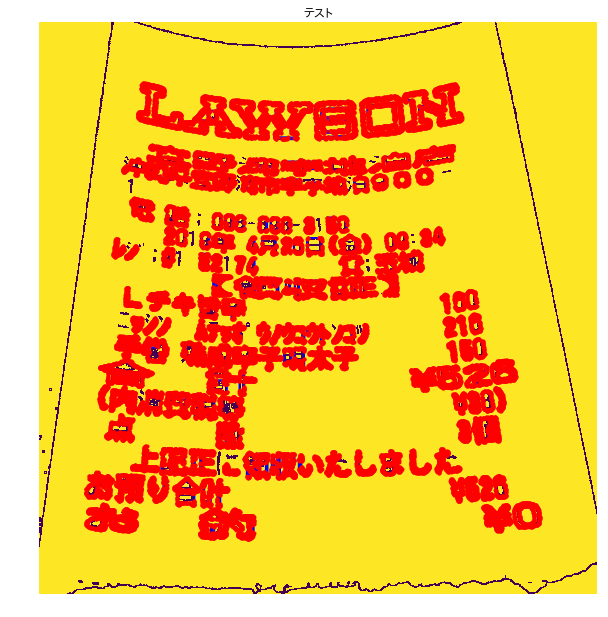

In [172]:
# 検出した矩形を描画
_, ax = plt.subplots(figsize=(10, 20))
ax.set_title('テスト')
draw_contours(ax, sub_img.copy(), filtered_c)
plt.show()

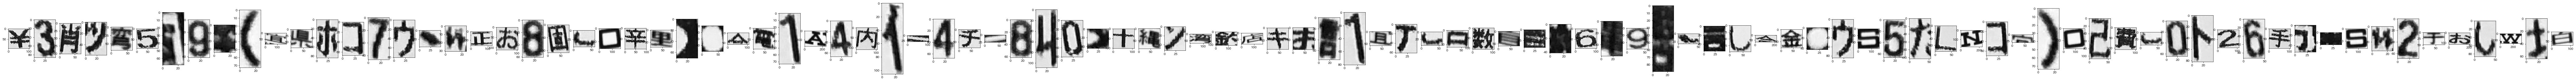

In [269]:
size = 100
_, axes = plt.subplots(ncols=size, figsize=(150, 30))
for idx, (c, ax) in enumerate(zip(np.random.choice(filtered_c, size=size, replace=False), axes)):
    x, y, w, h = cv2.boundingRect(c)
    
    ax.imshow(gray_img[y:y+h, x:x+w], cmap='gray')

plt.show()

↑画像をクリックしたら拡大します

(怪文章っぽい）

# Kerasで構築した手書きひらがな画像を予測してみる

In [180]:
!pip install keras tensorflow

    100% |████████████████████████████████| 92.6MB 19kB/s  eta 0:00:01-1 day, 23:59:49                     | 409kB 2.7MB/s eta 0:00:34    2% |▊                               | 2.2MB 5.5MB/s eta 0:00:17    2% |▉                               | 2.4MB 4.8MB/s eta 0:00:19    3% |█                               | 2.9MB 15.4MB/s eta 0:00:06    13% |████▎                           | 12.3MB 6.5MB/s eta 0:00:13    13% |████▍                           | 12.7MB 6.3MB/s eta 0:00:13    14% |████▋                           | 13.4MB 9.8MB/s eta 0:00:09    14% |████▊                           | 13.8MB 7.6MB/s eta 0:00:11    32% |██████████▌                     | 30.5MB 5.4MB/s eta 0:00:12    33% |██████████▊                     | 31.0MB 11.2MB/s eta 0:00:06    50% |████████████████                | 46.5MB 7.1MB/s eta 0:00:07        | 47.2MB 3.9MB/s eta 0:00:12    56% |██████████████████              | 52.1MB 10.8MB/s eta 0:00:04    56% |██████████████████              | 52.2MB 2.9MB/s eta 0:00:14   | 

In [249]:
# ラベル
# 何故かひらがなじゃないやつ混じっているけど
# 原因 -> https://github.com/yukoba/CnnJapaneseCharacter/issues/4
labels = list('あいうえおか平がきぎくぐけげこごさざしじすずせぜそぞただちぢつづてでとどなにぬねのはばぱひびぴふぶぷへべぺほぼぽまみむめもやゆよら開りるれろわん')

In [244]:
from keras import backend as K
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Bidirectional, LSTM
from keras.layers import Dense, Dropout, Activation, Flatten, Reshape
from keras.models import Sequential


def weight_variable(shape, name=None):
    return np.random.normal(scale=.01, size=shape)


def lstm_model(input_shape=(32, 32, 1), nb_classes=72):
    model = Sequential()
    model.add(Reshape((32, 32), input_shape=input_shape))
    model.add(Bidirectional(LSTM(256)))
    model.add(Dense(256))
    model.add(Dense(nb_classes, kernel_initializer=weight_variable))
    model.add(Activation('softmax'))
    
    return model


model = lstm_model()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

学習したモデルの結果は下記

>Epoch 50/50  
>576/576 [==============================] - 75s 130ms/step - loss: 0.1123 - acc: 0.9605 - auc: 0.9939 - val_loss: 0.2782 - val_acc: 0.9253 - val_auc: 0.9939

In [245]:
model.load_weights('./save.weights')

In [250]:
# 真っ黒な画像でテスト
test_img = np.ones((32, 32, 1)).reshape(1, 32, 32, 1)
label_id = np.argmax(model.predict(test_img), axis=1)[0]
labels[label_id]

'ざ'

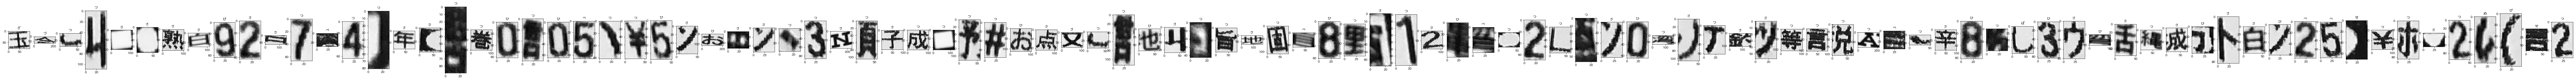

In [254]:
size = 100
_, axes = plt.subplots(ncols=size, figsize=(150, 30))
pred_imgs = []
for idx, (c, ax) in enumerate(zip(np.random.choice(filtered_c, size=size, replace=False), axes)):
    x, y, w, h = cv2.boundingRect(c)
    
    a = gray_img[y:y+h, x:x+w]
    ax.imshow(a, cmap='gray')
    
    pred_img = cv2.resize(a, (32, 32)).reshape(1, 32, 32, 1)
    pred_imgs.append(pred_img)
    label_id = np.argmax(model.predict(pred_img), axis=1)[0]
    ax.set_title(labels[label_id])
    
    np.argmax(model.predict(test_img), axis=1)

plt.show()

↑タイトルが予測した文字になっています

In [266]:
a = np.argmax(model.predict(np.array(pred_imgs).reshape(100, 32, 32, 1)), axis=1).tolist()
_preds = [labels[aa] for aa in a]
np.unique(_preds, return_counts=True)

(array(['ざ', 'せ', 'づ', 'ぱ', 'び', 'ぴ', 'ぺ', 'め'], dtype='<U1'),
 array([31,  2, 42,  1, 15,  1,  7,  1]))

完全に過学習です。本当にありがとうございました。